# Basic demo for FASHN VTON v1.5

FASHN VTON v1.5: Efficient Maskless Virtual Try-On in Pixel Space

GitHub: https://github.com/fashn-AI/fashn-vton-1.5

## Installation

In [ ]:
!git clone https://github.com/fashn-AI/fashn-vton-1.5
%cd fashn-vton-1.5

Cloning into 'fashn-vton-1.5'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 92 (delta 29), reused 82 (delta 19), pack-reused 0 (from 0)
Receiving objects: 100% (92/92), 333.37 KiB | 33.34 MiB/s, done.
Resolving deltas: 100% (29/29), done.
/content/fashn-vton-1.5


In [ ]:
!pip install .

Processing /content/fashn-vton-1.5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.6/252.6 MB 8.8 MB/s eta 0:00:00
  Created wheel for fashn-vton: filename=fashn_vton-1.5.0-py3-none-any.whl size=37601 sha256=222e921efd8f66192f9f64f6e9476b95dac9851dbecc895fadfd658b44c9b549
  Stored in directory: /root/.cache/pip/wheels/83/85/d4/003a2789df48fea4fd69c5093b73b4495d75e045a364d41756
Successfully built fashn-vton


In [ ]:
!python scripts/download_weights.py --weights-dir ./weights



model.safetensors: 100% 1.94G/1.94G [00:05<00:00, 337MB/s]
  Saved to: /content/fashn-vton-1.5/weights/model.safetensors

yolox_l.onnx: 100% 217M/217M [00:00<00:00, 303MB/s]
  Saved to: /content/fashn-vton-1.5/weights/dwpose/yolox_l.onnx
dw-ll_ucoco_384.onnx: 100% 134M/134M [00:00<00:00, 167MB/s]
  Saved to: /content/fashn-vton-1.5/weights/dwpose/dw-ll_ucoco_384.onnx

config.json: 1.65kB [00:00, 3.36MB/s]
model.safetensors: 100% 256M/256M [00:01<00:00, 204MB/s]
Loading weights: 100% 930/930 [00:01<00:00, 702.72it/s, Materializing param=segformer.encoder.patch_embeddings.3.proj.weight]
  Cached in HuggingFace hub cache

Download complete!

Weights directory structure:
    /content/fashn-vton-1.5/weights/
    ├── model.safetensors
    └── dwpose/
        ├── yolox_l.onnx
        └── dw-ll_ucoco_384.onnx

Usage:
    from fashn_vton import TryOnPipeline
    pipeline = TryOnPipeline(weights_dir="/content/fashn-vton-1.5/weights")



## Functionality test

In [ ]:
from IPython.display import display
from PIL import Image
from fashn_vton import TryOnPipeline
import matplotlib.pyplot as plt

In [ ]:
# Initialize pipeline (automatically uses GPU if available)
pipeline = TryOnPipeline(weights_dir="./weights")

# Load images
person = Image.open("examples/data/model.webp").convert("RGB")
garment = Image.open("examples/data/garment.webp").convert("RGB")

TryOnPipeline - INFO - Using device: cuda
TryOnPipeline - INFO - Using dtype: torch.bfloat16
TryOnPipeline - INFO - Loading TryOnModel from /content/fashn-vton-1.5/weights/model.safetensors
TryOnPipeline - INFO - TryOnModel loaded
TryOnPipeline - INFO - Loading DWPose from /content/fashn-vton-1.5/weights/dwpose
TryOnPipeline - INFO - DWPose loaded
TryOnPipeline - INFO - Loading FashnHumanParser
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading weights:   0%|          | 0/930 [00:00<?, ?it/s]

TryOnPipeline - INFO - FashnHumanParser loaded


In [ ]:
# Run inference
result = pipeline(
    person_image=person,
    garment_image=garment,
    category="tops",  # "tops" | "bottoms" | "one-pieces"
)

TryOnPipeline - INFO - Using device: cuda
TryOnPipeline - INFO - Using dtype: torch.bfloat16
TryOnPipeline - INFO - Loading TryOnModel from /content/fashn-vton-1.5/weights/model.safetensors
TryOnPipeline - INFO - TryOnModel loaded
TryOnPipeline - INFO - Loading DWPose from /content/fashn-vton-1.5/weights/dwpose
TryOnPipeline - INFO - DWPose loaded
TryOnPipeline - INFO - Loading FashnHumanParser
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading weights:   0%|          | 0/930 [00:00<?, ?it/s]

TryOnPipeline - INFO - FashnHumanParser loaded
TryOnPipeline - INFO - Running inference with 30 timesteps...


Sampling:   0%|          | 0/30 [00:00<?, ?it/s]

TryOnPipeline - INFO - Generated 1 images


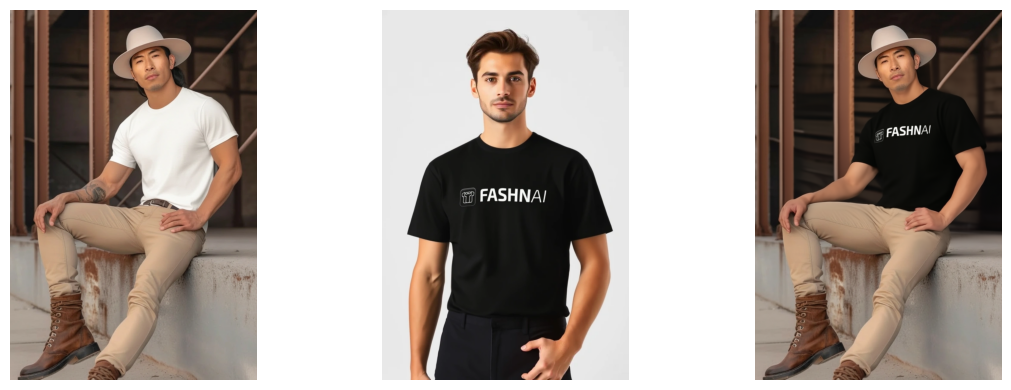

In [ ]:
imgs = [person, garment, result.images[0]]
plt.figure(figsize=(12, 4))
for i, img in enumerate(imgs, 1):
    plt.subplot(1, 3, i)
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()

# Gradio Demo

In [ ]:
import gradio as gr
from PIL import Image
import torch

def run_vton(person_img, garment_img, category):
    person_img = Image.fromarray(person_img)
    garment_img = Image.fromarray(garment_img)
    result = pipeline(
        person_image=person_img,
        garment_image=garment_img,
        category=category,
    )
    return result.images[0]

demo = gr.Interface(
    fn=run_vton,
    inputs=[
        gr.Image(type="numpy", label="Person"),
        gr.Image(type="numpy", label="Garment"),
        gr.Radio(
            choices=["tops", "bottoms", "one-pieces"],
            value="tops",
            label="Category",
        ),
    ],
    outputs=gr.Image(type="pil", label="Result"),
    title="Virtual Try-On Demo",
    description="Upload a person image and a garment image to generate a try-on result.",
)

demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://62ee617ca34303ab87.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Extending for multiple people

In [ ]:
import requests
from io import BytesIO

In [ ]:
url = "https://thumbs.dreamstime.com/b/full-length-portrait-group-young-men-wearing-jeans-looking-camera-smiling-35328409.jpg"

resp = requests.get(url, timeout=30)
resp.raise_for_status()

people = Image.open(BytesIO(resp.content)).convert("RGB")
people.save("examples/data/people.png")

In [ ]:
result = pipeline(
    person_image=people,
    garment_image=garment,
    category="tops",  # "tops" | "bottoms" | "one-pieces"
)

TryOnPipeline - INFO - Running inference with 30 timesteps...


Sampling:   0%|          | 0/30 [00:00<?, ?it/s]

TryOnPipeline - INFO - Generated 1 images


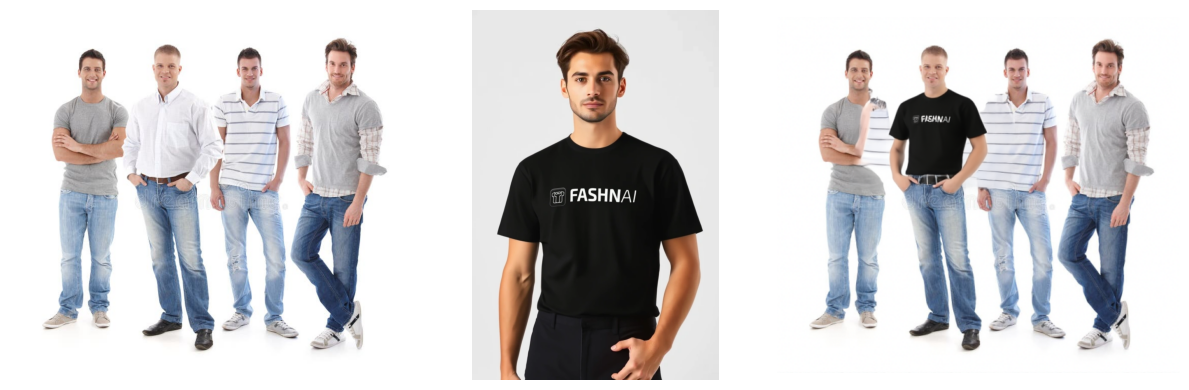

In [ ]:
imgs = [people, garment, result.images[0]]
plt.figure(figsize=(12, 4))
for i, img in enumerate(imgs, 1):
    plt.subplot(1, 3, i)
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()


## Baseline approach

As you can see from the above result, attempting to run this model for multiple subjects leads to a glitched output.

A simple appraoch would be to segment the original image by the people, apply to each individual, and then re-combine. For the segementation, we will use Ultralytics YOLO https://github.com/ultralytics/ultralytics.

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 83.5 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO
import cv2
import numpy as np

In [ ]:
# Load a model
model = YOLO("yolo26n-seg.pt")

# Predict with the model
results = model("examples/data/people.png")  # predict on an image


image 1/1 /content/fashn-vton-1.5/examples/data/people.png: 576x640 4 persons, 14.1ms
Speed: 2.6ms preprocess, 14.1ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)


In [ ]:
def get_mask(result, H, W):
  cls_ids = result.boxes.cls.cpu().numpy().astype(int)  # (N,)
  person_idxs = cls_ids == 0
  person_polygons = [poly for poly, keep in zip(result.masks.xy, person_idxs) if keep]
  masks = []
  for poly in person_polygons:
      mask = np.zeros((H, W), dtype=np.uint8)
      poly_int = np.round(poly).astype(np.int32)
      cv2.fillPoly(mask, [poly_int], 1)
      masks.append(mask.astype(bool))
  return masks

In [ ]:
img_bgr = cv2.imread("examples/data/people.png")
img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
H, W = img.shape[:2]

masks = get_mask(results[0], H, W)

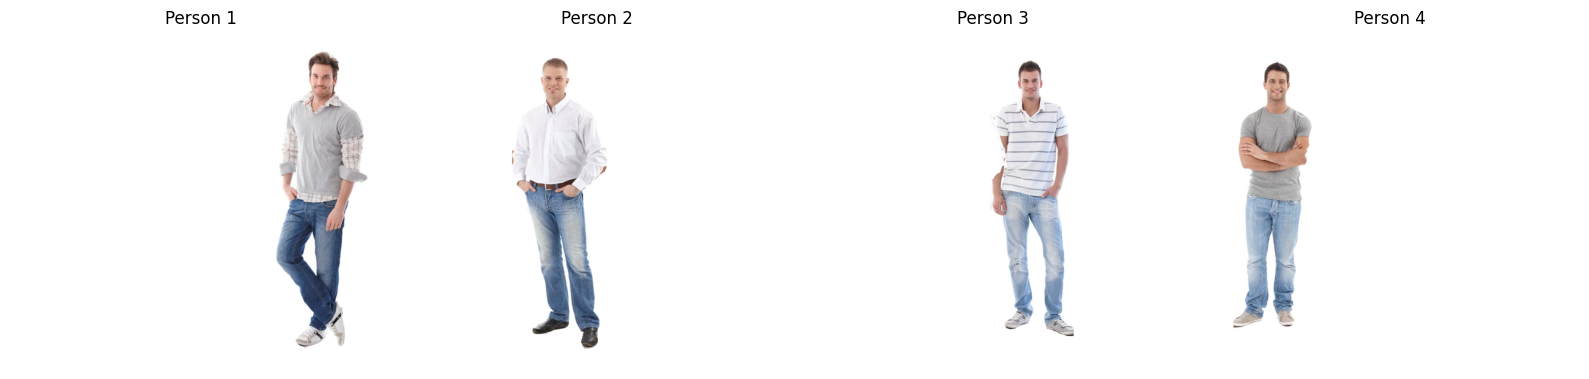

In [ ]:
img_bgr = cv2.imread("examples/data/people.png")
img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

people = []
for mask in masks:
    cutout = img.copy()
    cutout[~mask] = 255
    img_pil = Image.fromarray(cutout)
    people.append(img_pil)

# Plot side by side
plt.figure(figsize=(4 * len(people), 4))
for i, person in enumerate(people, 1):
    plt.subplot(1, len(people), i)
    plt.imshow(person)
    plt.title(f"Person {i}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
vton_people = []
for person in people:
  result = pipeline(
      person_image=person,
      garment_image=garment,
      category="tops",  # "tops" | "bottoms" | "one-pieces"
  )
  vton_people.append(result.images[0])

TryOnPipeline - INFO - Running inference with 30 timesteps...


Sampling:   0%|          | 0/30 [00:00<?, ?it/s]

TryOnPipeline - INFO - Generated 1 images
TryOnPipeline - INFO - Running inference with 30 timesteps...


Sampling:   0%|          | 0/30 [00:00<?, ?it/s]

TryOnPipeline - INFO - Generated 1 images
TryOnPipeline - INFO - Running inference with 30 timesteps...


Sampling:   0%|          | 0/30 [00:00<?, ?it/s]

TryOnPipeline - INFO - Generated 1 images
TryOnPipeline - INFO - Running inference with 30 timesteps...


Sampling:   0%|          | 0/30 [00:00<?, ?it/s]

TryOnPipeline - INFO - Generated 1 images


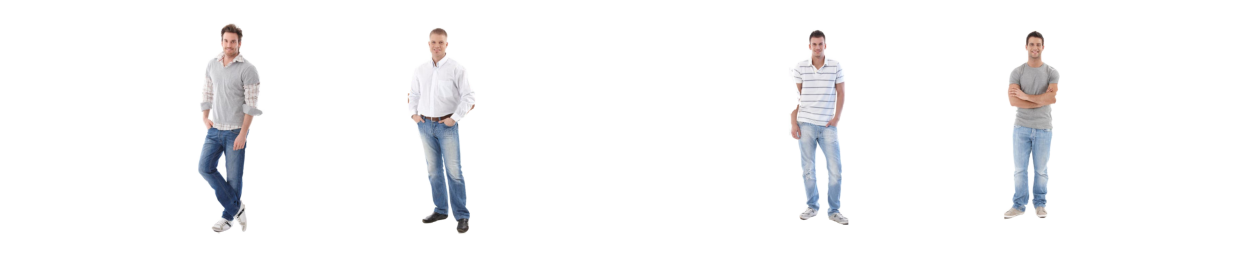

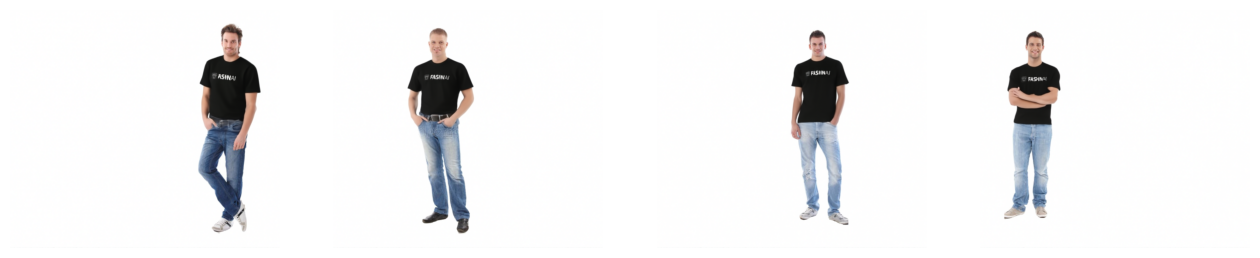

In [ ]:
plt.figure(figsize=(16, 8))
for i, person in enumerate(people, 1):
    plt.subplot(1, len(people), i)
    plt.imshow(person)
    plt.axis("off")
plt.figure(figsize=(16, 8))
for i, person in enumerate(vton_people, 1):
    plt.subplot(1, len(people), i)
    plt.imshow(person)
    plt.axis("off")

In [ ]:
vton_masks = []
for people in vton_people:
  W, H = people.size
  results = model(np.array(people))
  result = results[0]
  mask = get_mask(result, H, W)[0]
  vton_masks.append(mask)


0: 576x640 1 person, 14.7ms
Speed: 2.7ms preprocess, 14.7ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 640)

0: 576x640 1 person, 13.2ms
Speed: 2.5ms preprocess, 13.2ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)

0: 576x640 1 person, 13.0ms
Speed: 2.4ms preprocess, 13.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)

0: 576x640 1 person, 1 frisbee, 13.9ms
Speed: 2.4ms preprocess, 13.9ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


In [ ]:
img_bgr = cv2.imread("examples/data/people.png")
img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, vton_people[0].size)

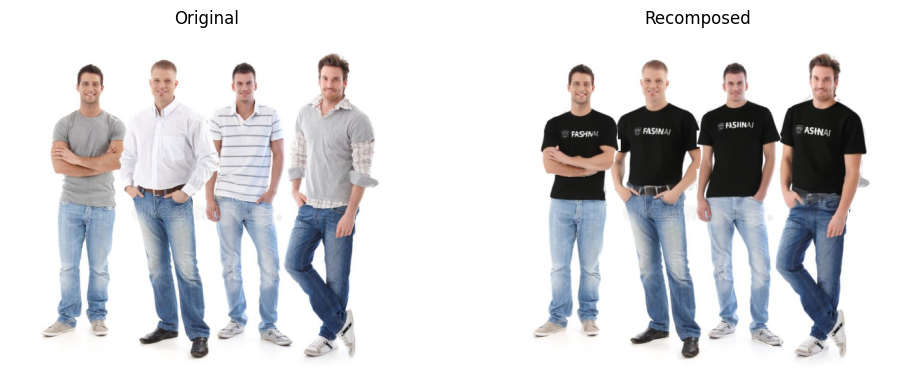

In [ ]:
# Start with a blank canvas (black background)
recomposed = img.copy()

for mask, vton_mask, img_pil in zip(masks, vton_masks, vton_people):
    recomposed[vton_mask] = np.array(img_pil)[vton_mask]

# Show side by side: original vs recomposed
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(recomposed)
plt.title("Recomposed")
plt.axis("off")

plt.tight_layout()
plt.show()

Looks ok, but there are a lot of cropping artifacts, especially where the people cover each other. Another peoplem in composing the images is that the shape and size of the clothes now differs from the original image. With the 4th person, you can see part of his old sleeve.

Instead of doing each person separately, it could work better to do them 1 by one, and then fill it in.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def union_edges_mask(masks, edge_width=2):
    """
    masks: list of HxW boolean masks
    edge_width: thickness of edge in pixels
    returns: HxW boolean mask of unioned edges
    """
    if len(masks) == 0:
        raise ValueError("No masks provided")

    H, W = masks[0].shape
    edge_union = np.zeros((H, W), dtype=np.uint8)

    kernel = np.ones((edge_width * 2 + 1, edge_width * 2 + 1), np.uint8)

    for m in masks:
        m_u8 = (m.astype(np.uint8) * 255)

        # Extract edges via morphological gradient
        edges = cv2.morphologyEx(m_u8, cv2.MORPH_GRADIENT, kernel)

        edge_union = np.maximum(edge_union, edges)

    return edge_union.astype(bool)

In [ ]:
edges_mask = union_edges_mask(vton_masks, edge_width=2)
mask_pil = Image.fromarray((edges_mask.astype(np.uint8) * 255), mode="L")
image_pil = Image.fromarray(recomposed)
image_pil

/tmp/ipython-input-1160558915.py:2: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_pil = Image.fromarray((edges_mask.astype(np.uint8) * 255), mode="L")
